In [1]:
#required imports for functionality
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import os

## file analysis
Firstly some exploration of the volumne of data so as I go through modeling I can check the shape status and category sount of each word to ensure things remain ordered.  Manual inspection of the audio files show there are some mislabeled files and I decide to leave them in for model robustness with the option to circle back and remove them.  Not all files are the same duration and I deal with that in notebook 2 after I choose which feature to use, I want to feature select before I preprocess.

In [16]:
#total filecount
words = sum([len(files) for r, d, files in os.walk('../data/speech_commands_v0.01')])
words

64729

In [5]:
#get a count of the word wave files by word category
filepath = '../data/speech_commands_v0.01/'
wav_dict = {}
for folder in os.listdir(filepath):
    count = 0
    if folder == ".DS_Store":
            continue
    if folder == 'validation_list.txt':
            continue
    if folder == 'LICENSE':     
            continue
    if folder == 'README.md':     
            continue
    if folder == 'testing_list.txt':
            continue
    for file in os.listdir(filepath +folder):
        if file.endswith('.wav'):
            count += 1          
    wav_dict[folder] = count
wav_dict

{'right': 2367,
 'eight': 2352,
 'cat': 1733,
 'tree': 1733,
 'bed': 1713,
 'happy': 1742,
 'go': 2372,
 'dog': 1746,
 'no': 2375,
 'wow': 1745,
 'nine': 2364,
 'left': 2353,
 'stop': 2380,
 'three': 2356,
 '_background_noise_': 6,
 'sheila': 1734,
 'one': 2370,
 'bird': 1731,
 'zero': 2376,
 'seven': 2377,
 'up': 2375,
 'marvin': 1746,
 'two': 2373,
 'house': 1750,
 'down': 2359,
 'six': 2369,
 'yes': 2377,
 'on': 2367,
 'five': 2357,
 'off': 2357,
 'four': 2372}

## explore an audio file
I explore some fundamental isolatable elements of an audio file to evaluate what may be good predictive features.
### raw wave
The raw waveform plots the oscillations of air pressure over time, the most direct visual translation of the complex vibrations our drums translate for us.

In [7]:
#this file is the word'right'
right, sr_r = librosa.load('../data/rest/me_right.wav')
ipd.Audio(right, rate =sr_r)

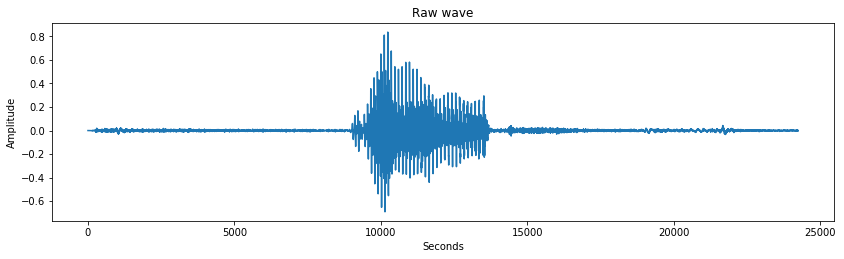

In [18]:
#the raw waveform before any decomposition
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Seconds')
ax1.plot(right);

### mel-spectogram
Visualizes sound intensity via log amplitude, also how humans perceive sound.

In [23]:
#convert to log scale, decibels, using peak power as reference
def spec(signal):
    R = librosa.feature.melspectrogram(signal)
    log_R = librosa.power_to_db(R, ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(log_R, x_axis='time', y_axis='mel')
    plt.title('Me saying' + signal)
    return plt.tight_layout()

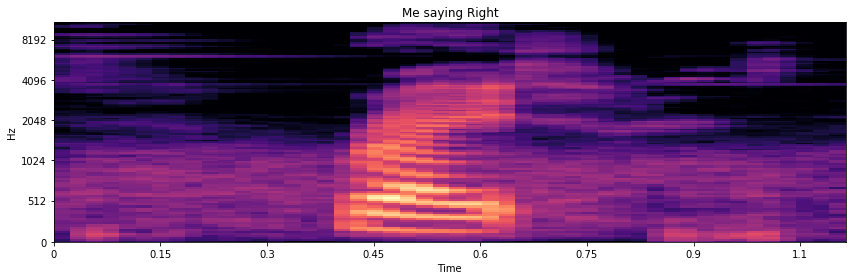

In [21]:
spec(right)

### onsets
Onset detection is an interesting fundamental of sound analysis, the librosa workflow below is how to visualize transitions in an audio signal.

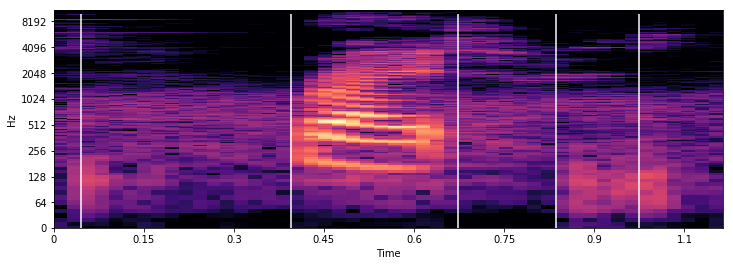

In [48]:
#convert estimated onsets into sample units, time, and plot.
hop_length = 512
onset_frames = librosa.onset.onset_detect(right, backtrack=True)
onset_times = librosa.frames_to_time(onset_frames)
onset_samples = librosa.frames_to_samples(onset_frames)
X = librosa.stft(right)
Xdb = librosa.amplitude_to_db(abs(X), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(Xdb, x_axis='time', y_axis='log')
plt.vlines(onset_times, 0, 10000, color='w');

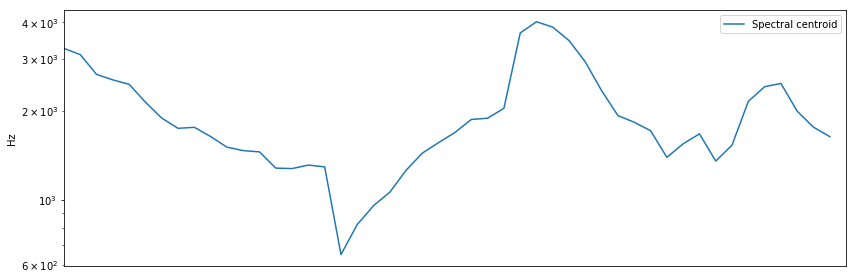

In [23]:
#
plt.figure(figsize=(12, 4))
cent = librosa.feature.spectral_centroid(right)
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, cent.shape[-1]])
plt.legend()
plt.tight_layout()

In [ ]:
#load and pull out some feature arrays
def features(signal):
    y, sr = librosa.load(signal)   
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=24)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    #average of mfccs
    mfcc = np.mean(mfcc.T, axis = 0)
    #average of deltas
    mfcc_delta = np.mean(mfcc_delta.T, axis = 0)
    # average of delta deltas
    mfcc_delta2 = np.mean(mfcc_delta2.T, axis = 0)
    return mfcc, mfcc_delta, mfcc_delta2

In [10]:
def mfcc(filepath, max_pad_len=11):
    wave, sr = librosa.load(filepath, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

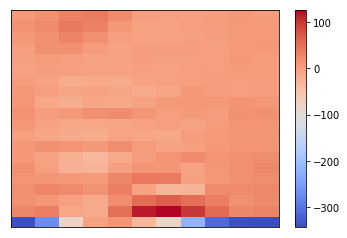

In [11]:
happy =mfcc('../data/speech_commands_v0.01/happy/146d97db_nohash_0.wav')
librosa.display.specshow(happy);
plt.colorbar();

## visualize
Loading in the chosen feature arrays from notebook 2

In [12]:
arrays = np.load('../data/rest/word_arrays.npy')
targets = np.load('../data/rest/word_targets.npy')

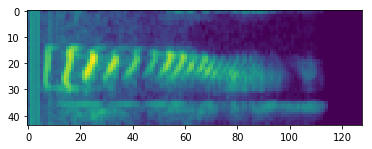

In [13]:
plt.imshow(arrays[0]);

0


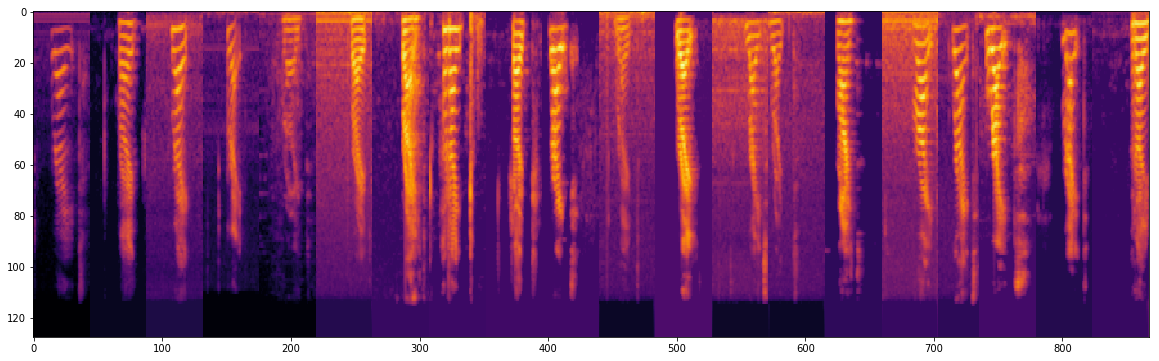

In [14]:
#20 people saying 'one'
array_plot = []
for array, target in zip(arrays, targets):
    array_plot.append(array)
    if len(array_plot) == 20:
        print(target)
        break
x = np.concatenate(array_plot, axis=0)  
plt.figure(figsize = (20, 6))
plt.imshow(x.T, cmap ='inferno', aspect ='auto');

30


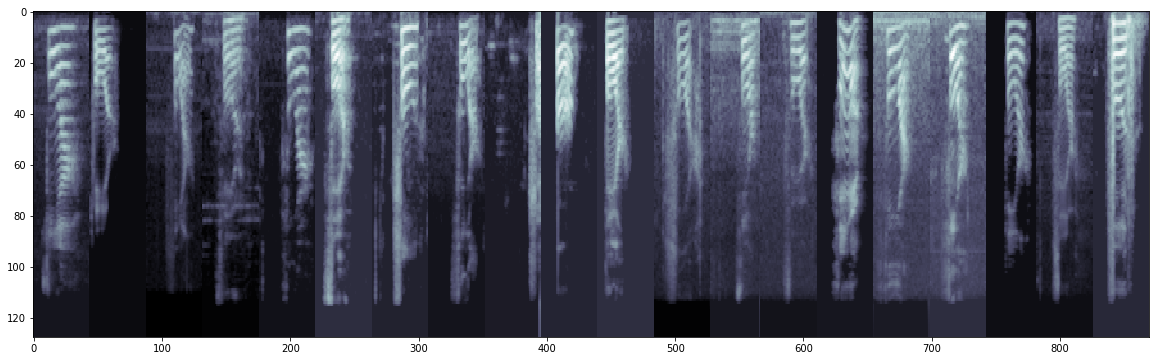

In [15]:
array_plot = []
for array, target in zip(arrays, targets):
    if target == 30:
        array_plot.append(array)
        if len(array_plot) == 20:
            print(target)
            break

x = np.concatenate(array_plot, axis=0)  
plt.figure(figsize = (20, 6))
plt.imshow(x.T, cmap = 'bone', aspect ='auto');